In [538]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

In [539]:
SEED = 1990
N_DAYS = 954
N_CLUSTERS = 6
N_TEST_DATA = 400
VAR_PERCENTILE_LEVEL = 5
METRIC = "dtw"
FONT = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

In [540]:
connection = pg.connect(database="postgres", user="postgres", password="Crypto01", host="localhost", port=5430)
cur = connection.cursor()

In [541]:
cur.execute("SELECT * FROM input.crypto_daily_changes ORDER BY date DESC LIMIT %s" % str(N_DAYS))
data = sorted(cur.fetchall(), key=lambda row: row[0], reverse=False)
daily_changes = pd.DataFrame(data=data, columns=[desc[0] for desc in cur.description], index=[row[0] for row in data], dtype="float64")
daily_changes = daily_changes.drop(["date"], axis=1)
daily_changes = daily_changes[daily_changes.index <= date(2018, 7, 31)]
daily_changes = daily_changes - 1
transpose_df = daily_changes.transpose()

In [542]:
transpose_df

,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2018-07-22,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-28,2018-07-29,2018-07-30,2018-07-31
AEON,0.030949,-0.073431,0.002903,-0.097052,0.069600,-0.032934,-0.029905,-0.071374,-0.110744,-0.320542,...,-0.006329,-0.006135,-0.022727,-0.017964,-0.018868,-0.024845,0.056962,0.011976,-0.023810,-0.064516
BAY,-0.296502,0.000000,-0.085601,0.124730,-0.110825,0.031182,0.242706,0.170705,0.166822,-0.285714,...,0.017270,0.099218,-0.072513,0.023782,0.025022,0.091453,-0.024547,0.002037,-0.016599,-0.059292
BLOCK,-0.265306,0.180451,-0.036252,0.009491,-0.066132,-0.042945,-0.003323,-0.009486,-0.127653,-0.124371,...,0.124051,-0.083513,-0.085960,-0.033011,-0.006855,0.015900,0.012285,-0.040519,-0.078947,-0.094542
BTC,0.009396,-0.000622,-0.006963,0.006083,-0.004892,-0.000881,0.060884,-0.009146,-0.010069,-0.004729,...,-0.000913,0.043165,0.087823,-0.026868,-0.028532,0.030967,0.005865,-0.001706,-0.004946,-0.053911
BTCD,-0.032787,0.000000,0.008547,-0.058824,-0.035714,-0.009259,0.000000,0.017699,-0.017544,0.000000,...,-0.021031,-0.095446,-0.110485,-0.039526,0.006728,-0.059304,-0.030957,-0.073433,0.009101,-0.128388
BURST,0.000000,0.000000,0.055462,0.000000,0.157818,0.000000,-0.091352,-0.099923,0.111029,-0.150045,...,-0.011390,-0.011046,-0.074606,0.006844,-0.043546,0.007098,0.045171,0.116505,-0.098790,-0.060345
CRW,0.000000,0.000000,0.877547,0.000000,0.000000,0.000000,0.841309,-0.009492,-0.007721,0.000000,...,-0.041381,-0.042213,0.015212,-0.080929,-0.198340,0.159338,-0.043519,0.127468,0.065827,-0.065036
DASH,0.177778,0.079137,0.033210,-0.035714,0.096296,-0.034483,-0.040741,-0.040000,-0.056818,0.293860,...,-0.016375,-0.054206,0.061271,-0.027141,-0.012032,0.007554,-0.014135,-0.006109,-0.015178,-0.077060
DGB,-0.062635,0.000000,0.000000,-0.033077,0.069600,-0.032934,0.000000,0.000000,0.466914,0.091187,...,0.031482,-0.017764,-0.103462,-0.001787,-0.040304,0.020950,-0.020626,-0.053315,0.009843,-0.051764
DOGE,-0.002770,-0.061111,0.000000,0.103704,0.047337,0.022599,-0.038122,-0.020678,0.045306,-0.113422,...,-0.019231,-0.024906,0.075007,-0.026475,-0.054849,0.035832,-0.025884,-0.046031,-0.001543,-0.077854


<Figure size 1440x1080 with 0 Axes>

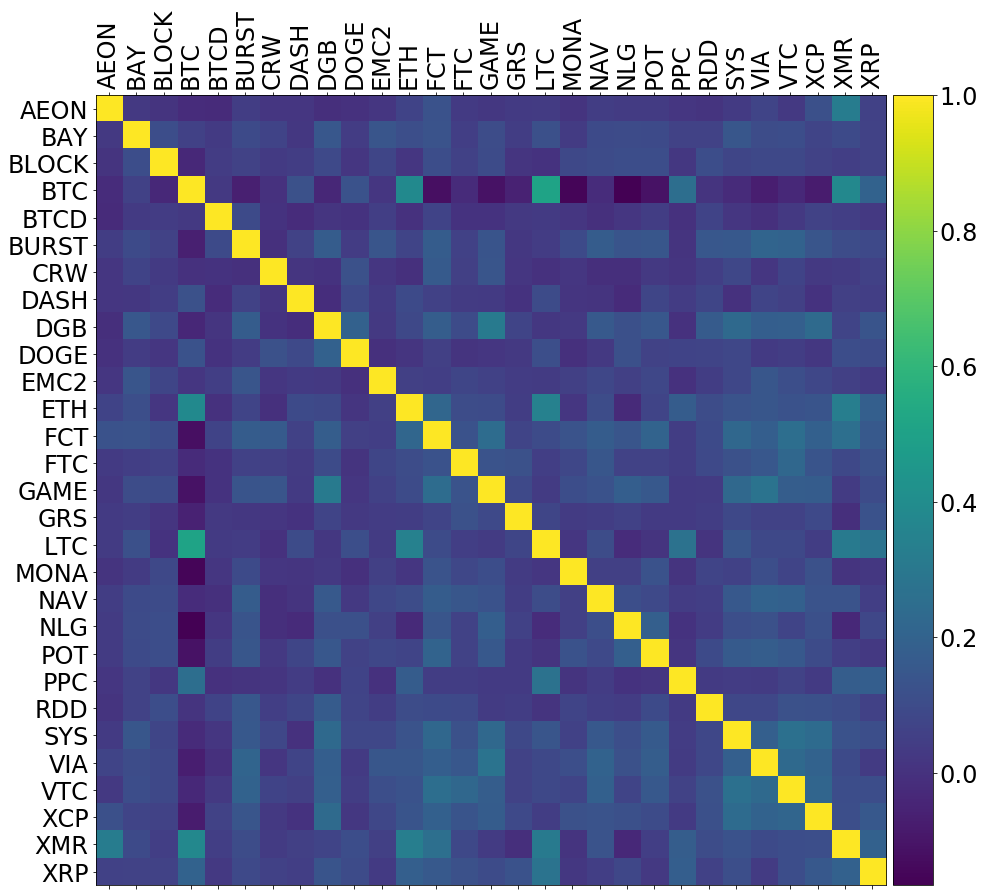

In [543]:
corr_mat = daily_changes.corr()
cryptos = np.array(corr_mat.columns)
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
plt.matshow(corr_mat)
plt.xticks(range(len(cryptos)), cryptos, rotation="vertical", fontsize=24)
plt.yticks(range(len(cryptos)), cryptos, fontsize=24)
# plt.xlabel("Correlation", fontdict=FONT)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(cax=cax)
plt.tick_params(labelsize=24)
plt.show()

In [544]:
training_data = np.array(transpose_df)

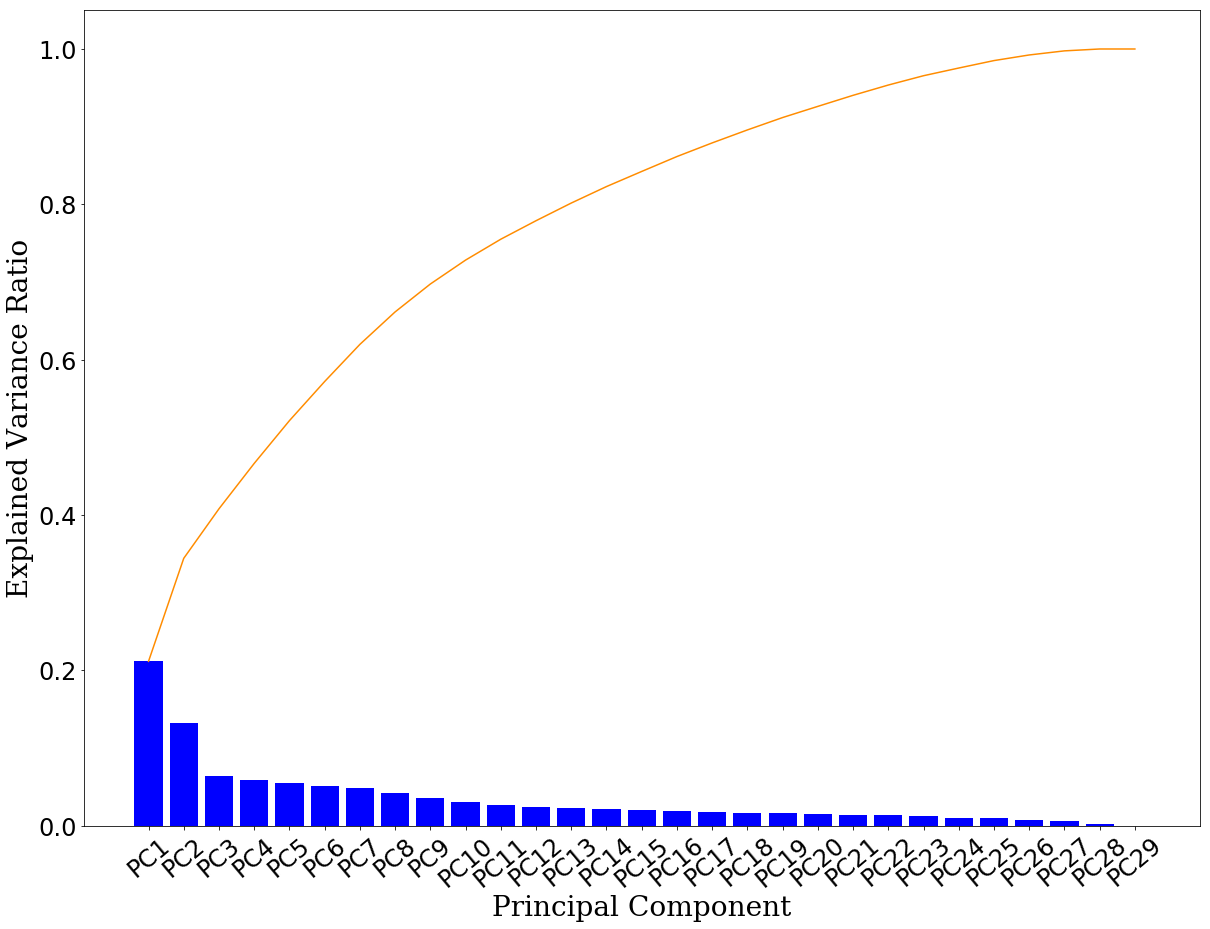

In [545]:
pca_plot = PCA(n_components=29)
pca_plot.fit(training_data)

cumsum_variance_ratio = np.cumsum(pca_plot.explained_variance_ratio_)
pc_names = ["PC" + str(i) for i in range(1, 30)]

plt.clf()
plt.plot(cumsum_variance_ratio, color="darkorange")
plt.bar(range(0, 29), pca_plot.explained_variance_ratio_, color="blue")
plt.yticks(fontsize=24)
plt.xticks(range(0, 29), pc_names, rotation=40, fontsize=24)
plt.xlabel("Principal Component", fontdict=FONT, fontsize=28)
plt.ylabel("Explained Variance Ratio", fontdict=FONT, fontsize=28)
plt.show()

In [546]:
pca = PCA(n_components=26)
training_data = pca.fit_transform(training_data)
dba_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, max_iter=100, metric=METRIC, verbose=True, max_iter_barycenter=10, random_state=SEED)
pred_clusters = dba_km.fit_predict(training_data)

4.700 --> 3.011 --> 2.891 --> 2.849 --> 2.742 --> 2.742 --> 


In [547]:
print("Percentage of interpretation:", sum(pca.explained_variance_ratio_))

Percentage of interpretation: 0.992303061323


In [548]:
for cluster in set(pred_clusters):
    print("Cluster", cluster, ":", cryptos[np.where(pred_clusters == cluster)])

Cluster 0 : ['BURST' 'MONA' 'POT' 'SYS' 'XCP' 'XRP']
Cluster 1 : ['CRW']
Cluster 2 : ['DOGE']
Cluster 3 : ['BTC' 'ETH' 'FCT' 'GAME' 'LTC' 'NLG' 'XMR']
Cluster 4 : ['AEON' 'BLOCK' 'BTCD' 'DGB' 'GRS' 'PPC' 'VIA' 'VTC']
Cluster 5 : ['BAY' 'DASH' 'EMC2' 'FTC' 'NAV' 'RDD']


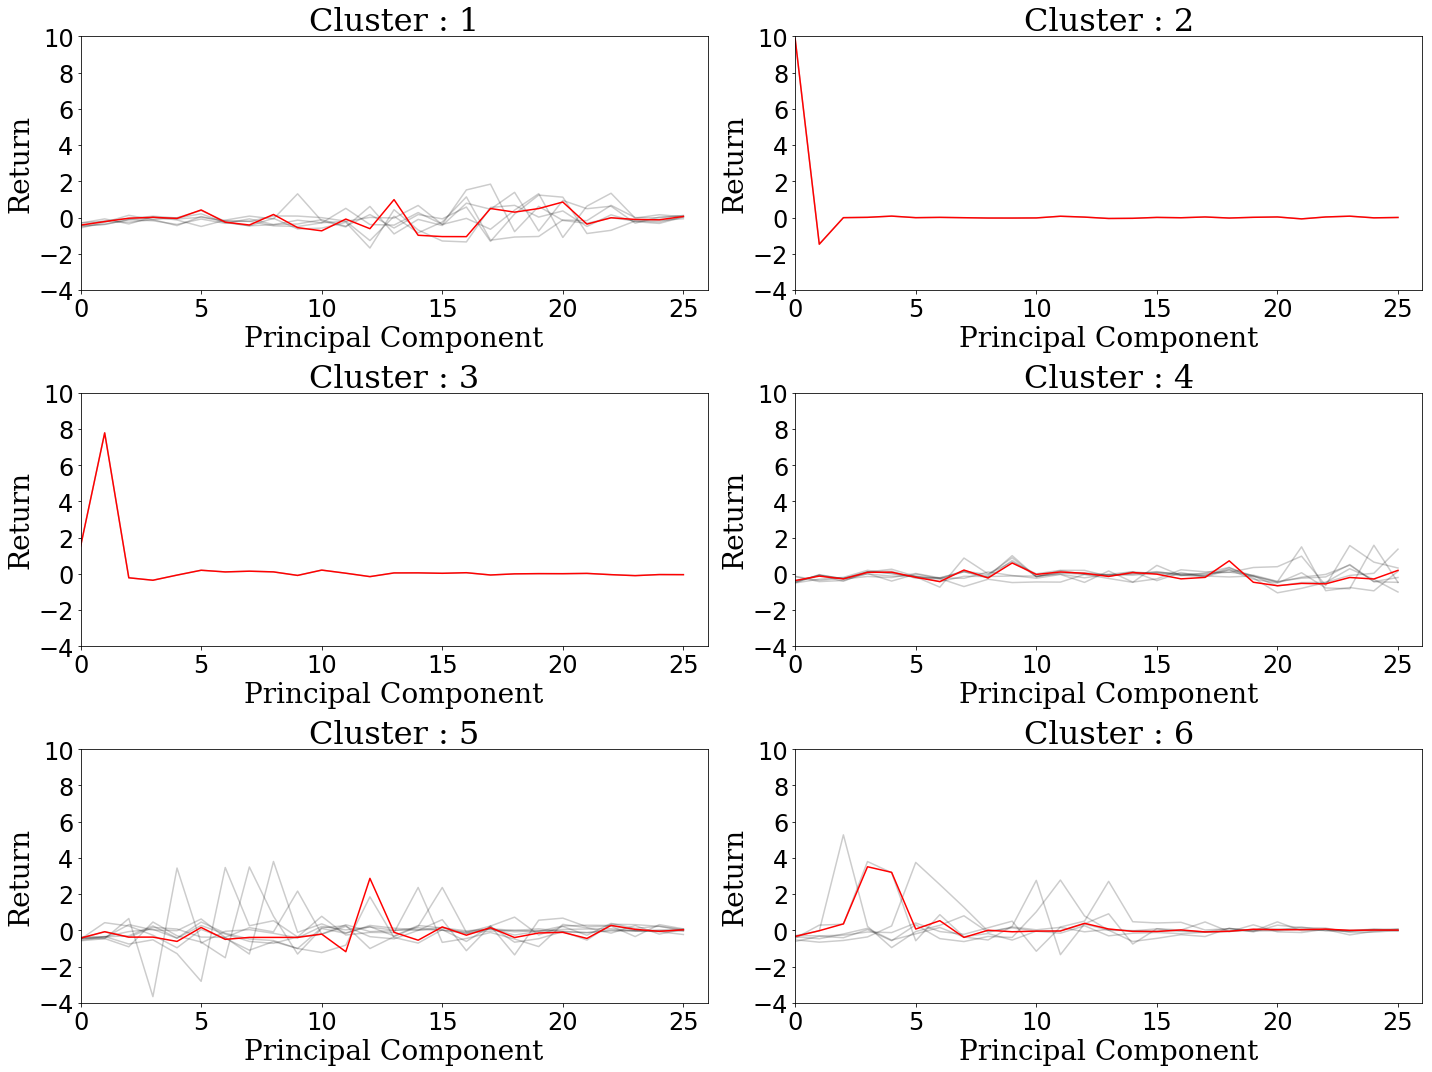

In [549]:
# Plot
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
for yi in set(pred_clusters):
    plt.subplot(N_CLUSTERS/3 + 1, 2, yi + 1)
    for xx in training_data[pred_clusters == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, training_data.shape[1])
    plt.ylim(-4, 10)
    title = "Cluster : " + str(yi + 1)
    plt.title(title, fontdict=FONT, fontsize=32)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Principal Component", fontdict=FONT, fontsize=28)
    plt.ylabel("Return", rotation="vertical", fontdict=FONT, fontsize=28)

plt.tight_layout()
plt.show()

In [550]:
training_clusterList = {}
training_varList = {}
test_clusterList = {}
test_varList = {}

training_list = transpose_df.iloc[:, N_TEST_DATA:]
training_var = [np.percentile(row, VAR_PERCENTILE_LEVEL) for row in np.array(training_list)]
test_list = transpose_df.iloc[:, :N_TEST_DATA]

In [551]:
for i in set(pred_clusters):
    training_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], N_TEST_DATA:]
    training_varList[i] = np.percentile(np.array(training_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    test_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], :N_TEST_DATA]
    test_varList[i] = np.percentile(np.array(test_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    
before = np.array([len(row[row < training_var[i]])/N_TEST_DATA for i, row in enumerate(np.array(test_list))])
after = []

for i in set(pred_clusters):
    after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(test_clusterList[i][test_clusterList[i] < training_varList[i]])])
   
after = np.hstack(after)

print("Before :", len(before[before < VAR_PERCENTILE_LEVEL/100])/len(before))
print("After :", len(after[np.where(after < VAR_PERCENTILE_LEVEL/100)])/len(after))

Before : 0.5172413793103449
After : 0.5862068965517241


In [552]:
before

array([ 0.09  ,  0.0525,  0.115 ,  0.0175,  0.025 ,  0.0325,  0.155 ,
        0.04  ,  0.0275,  0.0425,  0.035 ,  0.0475,  0.05  ,  0.05  ,
        0.0225,  0.07  ,  0.015 ,  0.0125,  0.095 ,  0.055 ,  0.0675,
        0.005 ,  0.0775,  0.03  ,  0.06  ,  0.035 ,  0.0525,  0.0525,
        0.0125])

In [553]:
training_before = np.array([len(row[row < training_var[i]])/(N_DAYS - N_TEST_DATA) for i, row in enumerate(np.array(training_list))])
training_after = []

for i in set(pred_clusters):
    training_after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(training_clusterList[i][training_clusterList[i] < training_varList[i]])])
    
training_after = np.hstack(training_after)

In [554]:
len(training_before[training_before > 0.0501])/len(training_before)

1.0

In [555]:
len(training_after[training_after > 0.0501])/len(training_after)

0.5172413793103449

In [556]:
before[before > 0.05]

array([ 0.09  ,  0.0525,  0.115 ,  0.155 ,  0.07  ,  0.095 ,  0.055 ,
        0.0675,  0.0775,  0.06  ,  0.0525,  0.0525])

In [557]:
after[after > 0.05]

array([ 0.0625,  0.155 ,  0.0575,  0.0625,  0.12  ,  0.105 ,  0.0875,
        0.0625,  0.0525,  0.0775,  0.1775])

In [558]:
print("p-value before clustering:", 1 - len(before[before > 0.055])/len(before[before > 0.05]))

p-value before clustering: 0.33333333333333337


In [559]:
print("p-value after clustering:", 1 - len(after[after > 0.055])/len(after[after > 0.05]))

p-value after clustering: 0.09090909090909094
